<a href="https://colab.research.google.com/github/lourencocavalcante/CAP-421-3-Deep-Learning/blob/main/Atividade01_Thales_Lourenco_DeepLearning_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" width = 500 align="left">](https://www.gov.br/inpe/pt-br)

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 300 align="right">](http://www.inpe.br/posgraduacao/cap/)

# **CAP-421-3 Aprendizado Profundo (*Deep Leraning*)**
## **Classificação de Imagens do EuroSAT com ResNet50: Substituição da Banda Azul pela Banda Infravermelha Próxima (NIR)**

**Docentes:** *Dr. Thales Sehn Körting*

**Discente:** *Lourenço José Cavalcante Neto*

---



## Objetivo

O objetivo desta atividade é criar duas classificações diferentes, explorando a base de dados EuroSAT com as bandas Vermelha, Verde e Infravermelha Próxima (RGNIR):

1. **Instanciar uma arquitetura bem conhecida** (por exemplo, ResNet50) com pesos aleatórios e treinar com o dataset EuroSAT (RGNIR).
2. **Instanciar a mesma arquitetura bem conhecida**, mas com pesos pré-treinados na ImageNet, e realizar um ajuste fino (fine-tuning) utilizando o dataset EuroSAT (RGNIR).

Além disso, será realizada a **exibição dos gráficos de precisão e perda ao longo das épocas**, para ambos os casos de treinamento.


In [ ]:
import zipfile
import requests
import io
import numpy as np
from PIL import Image

# URL do dataset EuroSAT
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# Faz o download e extrai o conteúdo do zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

# Lista apenas arquivos de imagens (.jpg)
rgnir_files = [f for f in z.namelist() if f.endswith('.jpg')]

print(f"Número total de imagens: {len(rgnir_files)}")

Número total de imagens: 27000


In [ ]:
# Inicializa listas para imagens e rótulos
X = []
labels = []

for file in rgnir_files:
    img = np.asarray(Image.open(z.open(file))).astype('uint8')

    # Calcula a pseudo-banda NIR (substituição da banda azul)
    # NIR é simulada pela média das bandas R e G
    nir_simulada = (img[:, :, 0] + img[:, :, 1]) / 2.0  # Pseudo NIR

    # Combina as bandas R, G e a pseudo NIR
    rgnir_img = np.dstack((img[:, :, 0], img[:, :, 1], nir_simulada)) / 255.0  # Normalização para 0-1

    X.append(rgnir_img)
    labels.append(file.split('/')[1])  # Extrai o rótulo da classe

# Converter para arrays NumPy
X = np.array(X)
label_names, y = np.unique(labels, return_inverse=True)
label_dictionary = dict(zip(np.unique(y), label_names))

print(f"Formato das imagens: {X.shape}")
print(f"Número de classes: {len(label_dictionary)}")

Formato das imagens: (27000, 64, 64, 3)
Número de classes: 10


## Visualização e comparação de imagens Originais (RGB) e Modificadas (RGNIR)

Formato das imagens originais: (27000, 64, 64, 3)
Formato das imagens RGNIR: (27000, 64, 64, 3)
Número de classes: 10


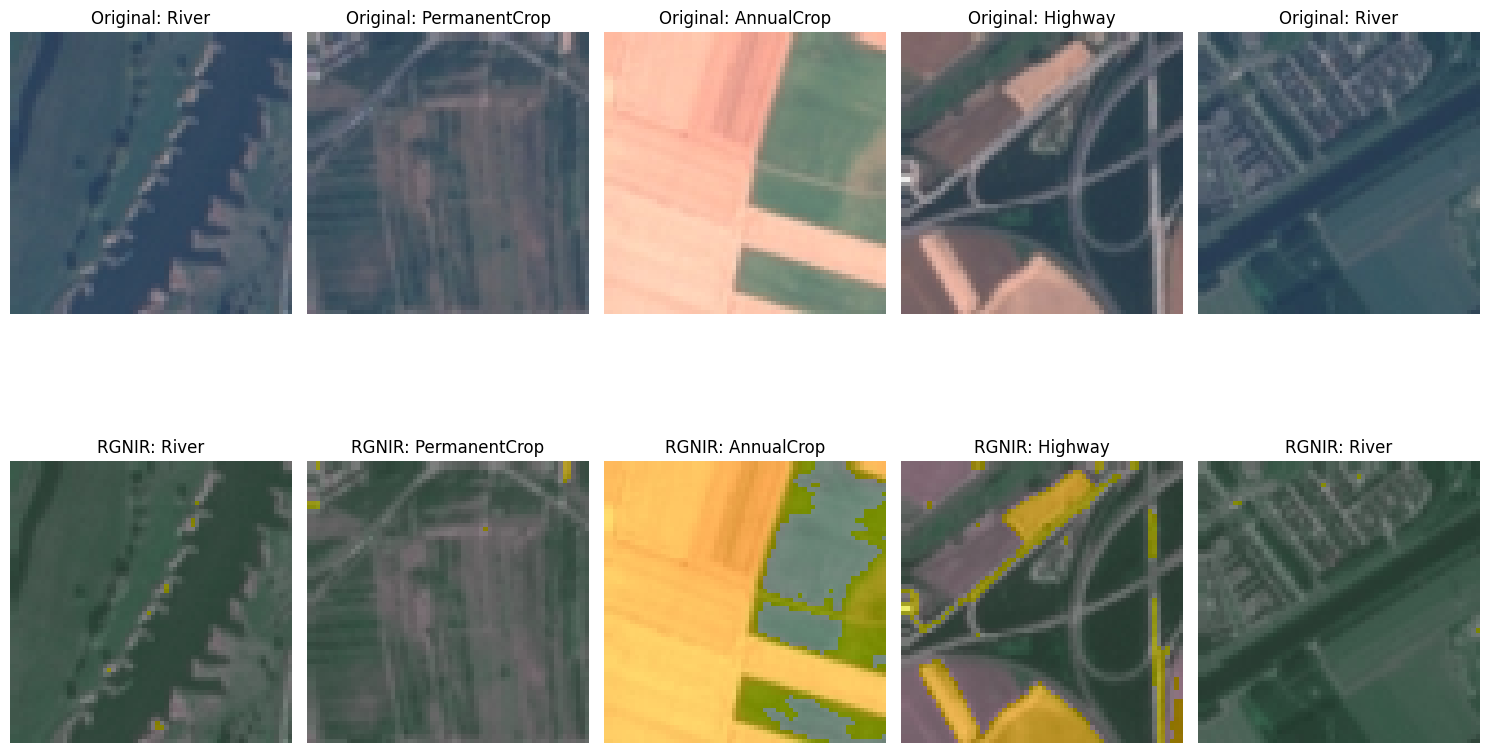

In [ ]:
import matplotlib.pyplot as plt

# Inicializa listas para imagens originais e rótulos
X_original = []
X_rgnir = []
labels = []

for file in rgnir_files:
    img = np.asarray(Image.open(z.open(file))).astype('uint8')

    # Armazena a imagem original (RGB normalizada)
    X_original.append(img / 255.0)

    # Calcula a pseudo-banda NIR (substituição da banda azul)
    nir_simulada = (img[:, :, 0] + img[:, :, 1]) / 2.0  # Média das bandas R e G (Pseudo NIR)

    # Combina as bandas R, G e a pseudo NIR
    rgnir_img = np.dstack((img[:, :, 0], img[:, :, 1], nir_simulada)) / 255.0

    # Armazena a imagem modificada (RGNIR)
    X_rgnir.append(rgnir_img)

    # Extrai o rótulo da classe
    labels.append(file.split('/')[1])

# Converter para arrays NumPy
X_original = np.array(X_original)
X_rgnir = np.array(X_rgnir)
label_names, y = np.unique(labels, return_inverse=True)
label_dictionary = dict(zip(np.unique(y), label_names))

print(f"Formato das imagens originais: {X_original.shape}")
print(f"Formato das imagens RGNIR: {X_rgnir.shape}")
print(f"Número de classes: {len(label_dictionary)}")

# Função para plotar amostras antes e depois da substituição da banda
def plot_comparison(X_orig, X_rgnir, y, label_dictionary, num_images=5):
    indices = np.random.choice(len(X_orig), num_images, replace=False)

    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices):
        # Imagem original (RGB)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X_orig[idx])
        plt.axis('off')
        plt.title(f"Original: {label_dictionary[y[idx]]}")

        # Imagem modificada (RGNIR)
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(X_rgnir[idx])
        plt.axis('off')
        plt.title(f"RGNIR: {label_dictionary[y[idx]]}")

    plt.tight_layout()
    plt.show()

# Visualiza amostras comparativas
plot_comparison(X_original, X_rgnir, y, label_dictionary, num_images=5)


## Divisão dos dados para Treinamento e Teste

In [ ]:
from sklearn.model_selection import train_test_split

# Divisão do dataset em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.75, random_state=42)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {len(y_train)}, y_test: {len(y_test)}")


X_train: (20250, 64, 64, 3), X_test: (6750, 64, 64, 3)
y_train: 20250, y_test: 6750


## Definições do modelo com pesos aleatórios e treinamento

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Aqui vamos realizar a definição do modelo com pesos aleatórios
random_model = ResNet50(weights=None, include_top=True, input_tensor=Input(shape=X_train.shape[1:]), classes=len(label_dictionary))
random_model.compile(optimizer=Adam(learning_rate=1e-4), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Treinamento do modelo com pesos aleatórios
history_random = random_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)

print("O Treinamento do modelo com pesos aleatórios foi finalizado.")


Epoch 1/30


I0000 00:00:1732034241.893076      98 service.cc:145] XLA service 0x7a01e4003870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732034241.893133      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/633 ━━━━━━━━━━━━━━━━━━━━ 8:00:11 46s/step - accuracy: 0.1250 - loss: 3.8892

I0000 00:00:1732034259.840388      98 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1732034259.876039      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


633/633 ━━━━━━━━━━━━━━━━━━━━ 91s 72ms/step - accuracy: 0.4290 - loss: 1.6822 - val_accuracy: 0.2283 - val_loss: 3.5331
Epoch 2/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.6283 - loss: 1.0658 - val_accuracy: 0.6421 - val_loss: 1.0128
Epoch 3/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.6882 - loss: 0.8938 - val_accuracy: 0.6972 - val_loss: 0.8305
Epoch 4/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7182 - loss: 0.8022 - val_accuracy: 0.5572 - val_loss: 1.3895
Epoch 5/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7482 - loss: 0.7124 - val_accuracy: 0.6575 - val_loss: 1.0536
Epoch 6/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7652 - loss: 0.6733 - val_accuracy: 0.6396 - val_loss: 3.1574
Epoch 7/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.7806 - loss: 0.6348 - val_accuracy: 0.5320 - val_loss: 2.0035
Epoch 8/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.8089 - loss: 0.5490 - val_accurac

## Definições do Modelo ResNet50 pré-treinado e treinamento

In [ ]:
from tensorflow.keras.layers import AveragePooling2D, Flatten, Dense, Dropout

# Modelo ResNet50 pré-treinado
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=X_train.shape[1:]))

# Adiciona camadas customizadas para ajuste fino
x = base_model.output
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Flatten(name='flatten')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(label_dictionary), activation='softmax')(x)

pretrained_model = Model(inputs=base_model.input, outputs=x)

# Congela as primeiras camadas do modelo pré-treinado
for layer in base_model.layers[:100]:
    layer.trainable = False

# Compilação do modelo para fine-tuning
pretrained_model.compile(optimizer=Adam(learning_rate=1e-4), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Treinamento com ajuste fino
history_pretrained = pretrained_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)

print("O Treinamento do modelo pré-treinado foi finalizado.")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 54s 48ms/step - accuracy: 0.4385 - loss: 1.5954 - val_accuracy: 0.1267 - val_loss: 8.0521
Epoch 2/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5942 - loss: 1.1576 - val_accuracy: 0.2302 - val_loss: 8.7187
Epoch 3/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6243 - loss: 1.0600 - val_accuracy: 0.1172 - val_loss: 19.5699
Epoch 4/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6305 - loss: 1.0356 - val_accuracy: 0.1596 - val_loss: 6.9953
Epoch 5/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6497 - loss: 0.9894 - val_accuracy: 0.2376 - val_loss: 3.8667
Epoch 6/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6587 - loss: 0.9516 - val_accuracy: 0.2711 - val_loss: 6.3307
Epoch 7/30
633/633 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6806 - loss: 0.8975 - val_accuracy: 0.2329 - val_loss: 7.2669
Epoch 8/30
633/633 ━━━━━━━━━━━━━━━━━━━

## Gráficos de Acurácia e Perda

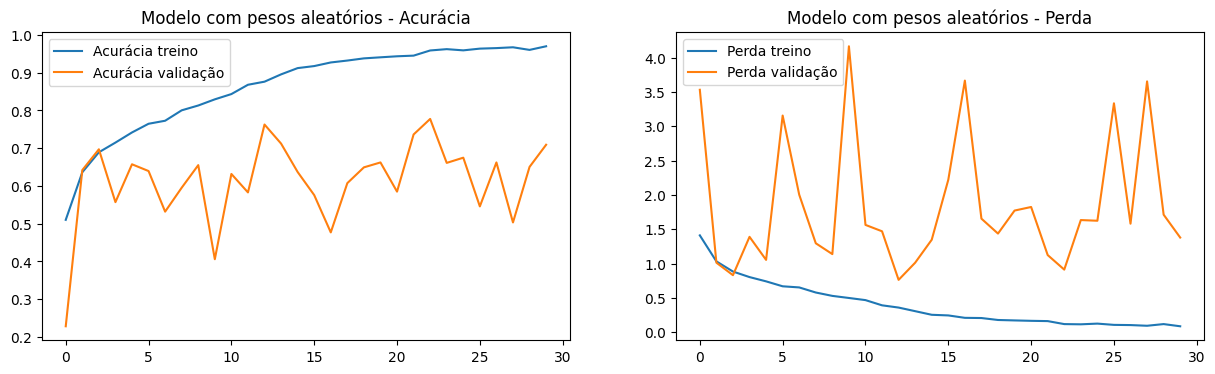

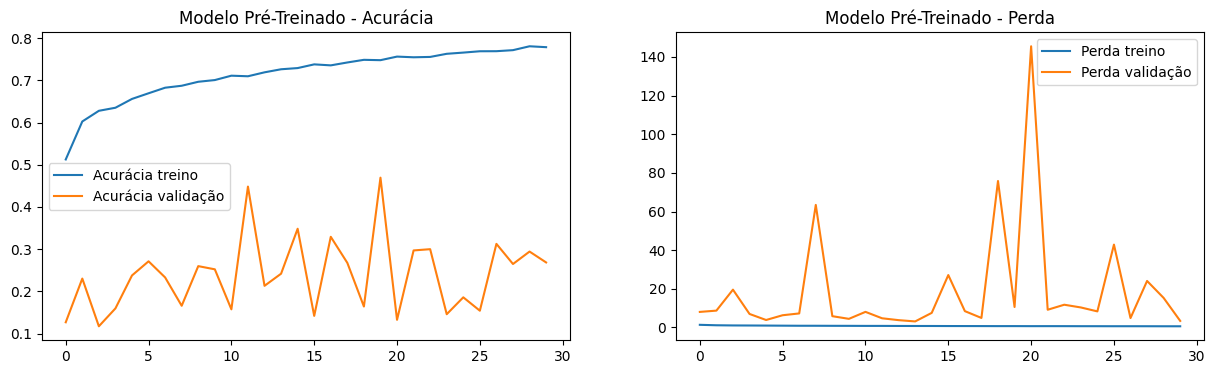

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar acurácia e perda
def plot_history(hist, title):
    plt.figure(figsize=(15, 4))

    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Acurácia treino')
    plt.plot(hist.history['val_accuracy'], label='Acurácia validação')
    plt.title(f'{title} - Acurácia')
    plt.legend()

    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Perda treino')
    plt.plot(hist.history['val_loss'], label='Perda validação')
    plt.title(f'{title} - Perda')
    plt.legend()

    plt.show()

# Plota os gráficos para ambos os modelos
plot_history(history_random, 'Modelo com pesos aleatórios')
plot_history(history_pretrained, 'Modelo Pré-Treinado')


## Avaliação dos Modelos

In [ ]:
# Avalia o desempenho final dos modelos no conjunto de teste
random_model_score = random_model.evaluate(X_test, y_test, verbose=0)
pretrained_model_score = pretrained_model.evaluate(X_test, y_test, verbose=0)

print(f"Modelo Pesos Aleatórios - Acurácia: {random_model_score[1]:.4f}")
print(f"Modelo Pré-Treinado - Acurácia: {pretrained_model_score[1]:.4f}")


Modelo Pesos Aleatórios - Acurácia: 0.7092
Modelo Pré-Treinado - Acurácia: 0.2684


211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


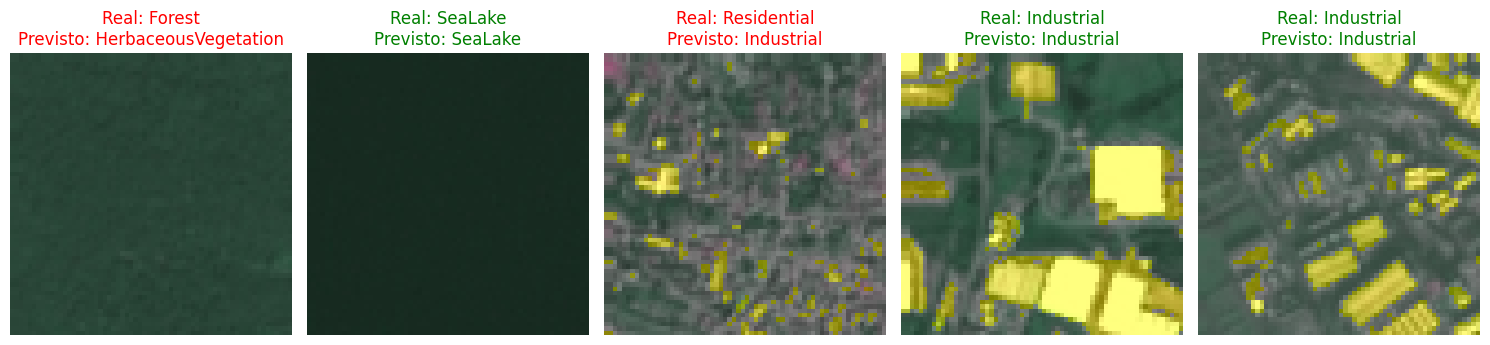

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar imagens com rótulos reais e previstos
def plot_predictions(model, X_test, y_test, label_dictionary, num_images=5):
    # Obtém as previsões do modelo
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)

    # Seleciona aleatoriamente algumas imagens para visualização
    indices = np.random.choice(range(len(X_test)), num_images, replace=False)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[idx])
        plt.axis('off')

        # Exibe rótulos real e previsto
        real_label = label_dictionary[y_test[idx]]
        predicted_label = label_dictionary[predicted_labels[idx]]
        color = 'green' if real_label == predicted_label else 'red'

        plt.title(f"Real: {real_label}\nPrevisto: {predicted_label}", color=color)

    plt.tight_layout()
    plt.show()

# Visualiza as previsões do modelo com pesos pré-treinados
plot_predictions(pretrained_model, X_test, y_test, label_dictionary)


# Referências

[tensorflow2021transfer] https://www.tensorflow.org/tutorials/images/transfer_learning

[keras2021transfer] https://www.tensorflow.org/guide/keras/transfer_learning

[cs231] **Convolutional Neural Networks for Visual Recognition**. Stanford Course. https://cs231n.github.io/transfer-learning

[yosinski2014how] Jason Yosinski, Jeff Clune, Yoshua Bengio, Hod Lipson. **How transferable are features in deep neural networks?** arXiv.org. https://arxiv.org/abs/1411.1792

[chollet2018] **Deep Learning with Phyton**. François Chollet. https://livebook.manning.com/book/deep-learning-with-python/

[penatti2015] O. Penatti et al. **Do deep features generalize from everyday
objects to remote sensing and aerial scenes domains?** IEEE
CVPR workshops.

[helber2019] P. Helber, B. Bischke, et al. **EuroSAT: A novel dataset and deep
learning benchmark for land use and land cover classification.** IEEE JSTARS.

[basu2015] S. Basu, S. Ganguly, et al. **Deepsat: A learning framework for
satellite imagery**. 23rd SIGSPATIAL.

[zhou2018] W. Zhou, S. Newsam, C. Li, and Z. Shao. **PatternNet: A benchmark dataset for performance evaluation of remote sensing image retrieval**. ISPRS P&RS.

[zhou2014] B. Zhou, A. Lapedriza, et al. **Learning deep features for scene
recognition using places database**. Advances in neural information processing systems.

[yang2010] Y. Yang and S. Newsam. **Bag-of-visual-words and spatial extensions for land-use classification**. SIGSPATIAL, GIS.
